In [1]:
#%pip install bertopic

In [2]:
# %pip install pandas
import pandas as pd
import numpy as np
from transformers import pipeline
import torch
from tqdm import tqdm

2025-06-17 19:38:10.813134: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-06-17 19:38:11.051851: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2025-06-17 19:38:11.051891: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2025-06-17 19:38:11.090134: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-17 19:38:12.063649: W tensorflow/stream_executor/platform/de

In [3]:
df = pd.read_csv('data.csv', encoding='windows-1252', header=None, usecols=[2, 5])

In [26]:
df['date'] = pd.to_datetime(df[2].astype(str))
df = df.drop(columns=[2]).rename(columns={5: 'tweet'})

/home/wladek/.local/lib/python3.8/site-packages/dateutil/parser/_parser.py:1207: UnknownTimezoneWarning: tzname PDT identified but not understood.  Pass `tzinfos` argument in order to correctly return a timezone-aware datetime.  In a future version, this will raise an exception.
  warnings.warn("tzname {tzname} identified but not understood.  "


In [5]:
from transformers import AutoModelForSequenceClassification, TFAutoModelForSequenceClassification
from transformers import AutoTokenizer
import numpy as np
from scipy.special import expit

    
MODEL = f"cardiffnlp/tweet-topic-base-multilingual"
tokenizer = AutoTokenizer.from_pretrained(MODEL)

# PT
model = AutoModelForSequenceClassification.from_pretrained(MODEL)
class_mapping = model.config.id2label

text = "Israeli drone strikes"
tokens = tokenizer(text, return_tensors='pt')
output = model(**tokens)

scores = output[0][0].detach().numpy()
scores = expit(scores)
predictions = (scores >= 0.5) * 1

In [6]:
class_mapping[scores.argmax()]

'news_&_social_concern'

In [4]:
import json

with open("data/sentiment140_label_mapping.json", "w", encoding="utf-8") as f:
    json.dump(class_mapping, f, ensure_ascii=False, indent=4)

In [7]:
tokens = [tokenizer(i, return_tensors='pt') for i in df[5].to_list()]

In [16]:
fe_pipeline = pipeline(
    task="text-classification",
    model=MODEL,
    torch_dtype=torch.float16,
    device=0
)

In [17]:
fe_pipeline("Israeli drone strikes")

[{'label': 'news_&_social_concern', 'score': 0.9805060625076294}]

In [21]:
inverse_class_mapping = {val: key for key, val in class_mapping.items()}
inverse_class_mapping

{'arts_&_culture': 0,
 'business_&_entrepreneurs': 1,
 'celebrity_&_pop_culture': 2,
 'diaries_&_daily_life': 3,
 'family': 4,
 'fashion_&_style': 5,
 'film_tv_&_video': 6,
 'fitness_&_health': 7,
 'food_&_dining': 8,
 'gaming': 9,
 'learning_&_educational': 10,
 'music': 11,
 'news_&_social_concern': 12,
 'other_hobbies': 13,
 'relationships': 14,
 'science_&_technology': 15,
 'sports': 16,
 'travel_&_adventure': 17,
 'youth_&_student_life': 18}

In [22]:
output = [inverse_class_mapping[fe_pipeline(t)[0]['label']] for t in df[5]]
print(len(output))

1600000


In [23]:
output[0]

6

In [24]:
df['topic'] = output

In [31]:
df.to_parquet('refined.parquet')

In [27]:
df

,tweet,date,topic
0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",2009-04-06 22:19:45,6
1,is upset that he can't update his Facebook by ...,2009-04-06 22:19:49,3
2,@Kenichan I dived many times for the ball. Man...,2009-04-06 22:19:53,16
3,my whole body feels itchy and like its on fire,2009-04-06 22:19:57,3
4,"@nationwideclass no, it's not behaving at all....",2009-04-06 22:19:57,3
...,...,...,...
1599995,Just woke up. Having no school is the best fee...,2009-06-16 08:40:49,3
1599996,TheWDB.com - Very cool to hear old Walt interv...,2009-06-16 08:40:49,6
1599997,Are you ready for your MoJo Makeover? Ask me f...,2009-06-16 08:40:49,5
1599998,Happy 38th Birthday to my boo of alll time!!! ...,2009-06-16 08:40:49,14


<Axes: >

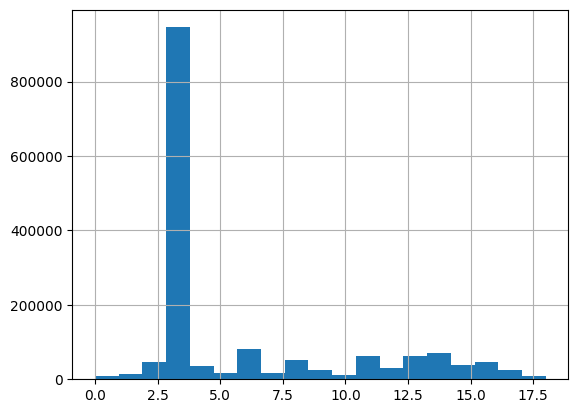

In [30]:
df['topic'].hist(bins=19)